<a href="https://colab.research.google.com/github/aleksandarb99/profession-and-gender-recognition/blob/develop/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETEKCIJA OSOBE PRAVA

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


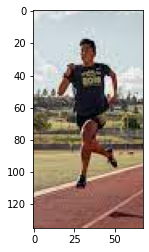

In [38]:
import cv2
import imutils
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt


drive.mount('/content/gdrive')
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"

# Initializing the HOG person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Reading the Image
image = cv2.imread(execution_path + 'test-images/aca.jpg')

# Resizing the Image
# image = imutils.resize(image,width=min(400, image.shape[1]))

# Detecting all the regions in the image that has a pedestrians inside it
(regions, _) = hog.detectMultiScale(image,winStride=(4, 4),padding=(4, 4),scale=1.05)

# Drawing the regions in the Image
cropped_image = None
for (x, y, w, h) in regions:
    # cv2.rectangle(image, (x, y),(x + w, y + h),(0, 0, 255), 2)
    # TODO pronadji najbolju opciju medju nadjenima
    max_space = 0
    if(w * h > max_space):
      max_space = w * h
      cropped_image = cropped_image = image[y:y+h, x:x+w]

# Showing the output Image
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))



# DETEKCIJA OSOBE

In [ ]:
# -----------------------------DETEKCIJA OSOBE---------------------------------

import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import math
from sklearn.datasets import fetch_lfw_people
from skimage import data, transform
from skimage import data, color, feature
from sklearn.feature_extraction.image import PatchExtractor
import pickle
import glob
from google.colab import drive
from os.path import exists
from skimage import data, transform
%matplotlib inline

drive.mount('/content/gdrive')
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# POMOCNE FUNKCIJE

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

def classify_window(window, clf, hog):
    features = hog.compute(window).reshape(1, -1)
    return clf.predict_proba(features)[0][1]

def process_image(image, clf, hog, step_size, window_size=(85,105)):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = classify_window(window, clf, hog)
                if score > best_score:
                    best_score = score
                    best_window = this_window
                    w = window
    return best_score, best_window, w

def scale(size):
  first = size[0]
  addedTen = first + 20
  x = math.floor(size[1] * addedTen / first)
  return (addedTen, x)

def scale_to_normal_size(image):
  if image.shape[0] < image.shape[1]:
    h = math.floor(300 * image.shape[0] / image.shape[1])
    return cv2.resize(image, (300, h))
  else:
    h = math.floor(300 * image.shape[1] / image.shape[0])
    return cv2.resize(image, (h, 300))

def get_hog(size):
  img = positive_patches[0]
  img = cv2.resize(img, size)
  img = img.astype(np.uint8)

  nbins = 9 # broj binova
  cell_size = (8, 8) # broj piksela po celiji
  block_size = (3, 3) # broj celija po bloku

  return cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

def get_best_image(scores):
  max_score = 0
  max_score_tupple = None
  for score_tupple in scores:
    if score_tupple[0] > max_score:
       max_score = score_tupple[0]
       max_score_tupple = score_tupple
  return max_score_tupple

In [ ]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

image_files = [f for f in glob.glob(execution_path + "person_detection_train" + "/**/*", recursive=True) if not os.path.isdir(f)] 
positive_patches = []

for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (100, 100))
    positive_patches.append(image)

shape = positive_patches[0].shape
def extract_patches(img, N, scale=1.0, patch_size=(62, 47)):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

def train_nn(size):
  pos_features = []
  neg_features = []
  labels = []
  x = None
  y = None

  hog = get_hog(size)

  index1 = 0
  for img in positive_patches:
    if(index1 == int(len(positive_patches)/6)):
      break
    img = cv2.resize(img, size)
    img = img.astype(np.uint8)
    pos_features.append(hog.compute(img))
    labels.append(1)
    index1 = index1 + 1

  index2 = 0
  for img in negative_patches:
    if(index2 == int(len(negative_patches)/6)):
      break
    img = cv2.resize(img, size)
    img = img.astype(np.uint8)
    neg_features.append(hog.compute(img))
    labels.append(0)
    index2 = index2 + 1

  pos_features = np.array(pos_features)
  neg_features = np.array(neg_features)
  x = np.vstack((pos_features, neg_features))
  y = np.array(labels)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  x_train = reshape_data(x_train)
  x_test = reshape_data(x_test)

  clf_svm = SVC(kernel='linear', probability=True) 
  clf_svm.fit(x_train, y_train)
  y_train_pred = clf_svm.predict(x_train)
  y_test_pred = clf_svm.predict(x_test)
  return clf_svm, hog

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


In [ ]:
# FORMIRANJE MODELA

clf_hog = []

def load_files():
  for index in range(10):
    f1=open(execution_path + "weights2/svcs/svc"+ str(index) + ".txt",'r+b')
    clf = pickle.load(f1)
    f1.close()
    f2=open(execution_path + "weights2/sizes/size"+ str(index) + ".txt",'r+b')
    size = pickle.load(f2)
    f2.close()
    hog = get_hog(size)
    clf_hog.append((clf, hog, size))

def train():
  size = (50,50)
  for x in range(10):
    clf, hog = train_nn(size)
    clf_hog.append((clf, hog, size))
    size = scale(size)

def save_files():
  index = 0
  for x in clf_hog:
    f1=open(execution_path + "weights2/svcs/svc"+ str(index) + ".txt",'w+b')
    pickle.dump(x[0],f1)
    f1.close()
    f2=open(execution_path + "weights2/sizes/size"+ str(index) + ".txt",'w+b')
    pickle.dump(x[2],f2)
    f2.close()
    index += 1
  print("Serialized")

if exists(execution_path + "weights2/svcs/svc0.txt"):
  load_files()
else:
  train()
  save_files()

0.9852652512157914


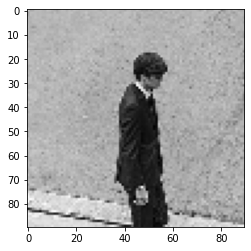

In [ ]:
# TESTIRANJE
itest = load_image(execution_path + 'test-images/11.jpg')
itest = scale_to_normal_size(itest)
scores = []
for x in clf_hog:
  score, score_window, w = process_image(itest, x[0], x[1], step_size=10, window_size=x[2])
  scores.append((score, score_window, w))
image = get_best_image(scores)
display_image(image[2])
print(image[0])

# KLASIFIKACIJA PROFESIJA

In [ ]:
from __future__ import print_function
import os
from io import open
import requests
import shutil
import numpy as np
import json
from IPython.display import Image
from zipfile import ZipFile
from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.preprocessing import image
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"
DATASET_DIR = os.path.join(execution_path, "idenprof")
DATASET_TRAIN_DIR = os.path.join(DATASET_DIR, "train")
DATASET_TEST_DIR = os.path.join(DATASET_DIR, "test")
CLASS_INDEX = None
MODEL_PATH = os.path.join(execution_path, "idenprof_VGG16_053-0.726.h5")
JSON_PATH = os.path.join(execution_path, "idenprof_model_class.json")

In [ ]:
# POMOCNE FUNKCIJE

def preprocess_input(x):
    x *= (1. / 255)
    return x

def decode_predictions(preds, top=5, model_json=""):
    global CLASS_INDEX
    if CLASS_INDEX is None:
        CLASS_INDEX = json.load(open(model_json))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        for i in top_indices:
            each_result = []
            each_result.append(CLASS_INDEX[str(i)])
            each_result.append(pred[i])
            results.append(each_result)
    return results
    
def run_inference(model,picture):
    image_to_predict = image.load_img(picture, target_size=(224, 224))
    image_to_predict = image.img_to_array(image_to_predict, data_format="channels_last")
    image_to_predict = np.expand_dims(image_to_predict, axis=0)

    image_to_predict = preprocess_input(image_to_predict)

    prediction = model.predict(x=image_to_predict, steps=1)

    predictiondata = decode_predictions(prediction, top=int(5), model_json=JSON_PATH)

    for result in predictiondata:
        print(str(result[0]), " : ", str(result[1] * 100))

def train_network(model):
    optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)
    batch_size = 32
    num_classes = 10
    epochs = 3
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    train_datagen = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator = train_datagen.flow_from_directory(DATASET_TRAIN_DIR, target_size=(224, 224),batch_size=batch_size,
                                                        class_mode="categorical")
    test_generator = test_datagen.flow_from_directory(DATASET_TEST_DIR, target_size=(224, 224), batch_size=batch_size,
                                                      class_mode="categorical")
    model.fit_generator(train_generator, steps_per_epoch=int(9000 / batch_size), epochs=epochs,
                        validation_data=test_generator,validation_steps=int(2000 / batch_size),
                        callbacks=[checkpoint])

In [ ]:
# FORMIRANJE MODELA

save_direc = os.path.join(os.getcwd(), 'idenprof_models')
model_name = 'idenprof_weight_model_VGG19.{epoch:03d}-{val_acc}.h5'
if not os.path.isdir(save_direc):
    os.makedirs(save_direc)
modelpath = os.path.join(save_direc, model_name)
checkpoint = ModelCheckpoint(filepath = modelpath, monitor = 'val_acc', verbose = 1, save_best_only = True,
                             save_weights_only = True, period=1)
input_shape = (224, 224, 3)

model = Sequential(
    [Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
     Conv2D(64, (3, 3), activation='relu', padding='same'),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(128, (3, 3), activation='relu', padding='same'),
     Conv2D(128, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Flatten(),
     Dense(10, activation="softmax")])
model.summary()

train_network(model)
model.load_weights(MODEL_PATH)
optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(DATASET_TEST_DIR, target_size=(224, 224), batch_size = 32,
                                                  class_mode="categorical")
loss,accuracy = model.evaluate_generator(test_generator,steps=int(2000 / 32))
print("Accuracy =", accuracy)

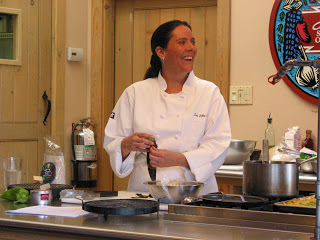

chef  :  95.45511603355408
waiter  :  2.166222594678402
mechanic  :  1.8960759043693542
engineer  :  0.3939555957913399
firefighter  :  0.05119987181387842


In [ ]:
# TESTIRANJE

picture = os.path.join(execution_path, "test-images/1.jpg")
display(Image(filename=picture))
run_inference(model,picture)

# DETEKCIJA LICA

In [ ]:
# -----------------------------DETEKCIJA LICA---------------------------------

import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import math
from sklearn.datasets import fetch_lfw_people
from skimage import data, transform
from skimage import data, color, feature
from sklearn.feature_extraction.image import PatchExtractor
import pickle
from google.colab import drive
from os.path import exists
from skimage import data, transform
%matplotlib inline

drive.mount('/content/gdrive')
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# POMOCNE FUNKCIJE

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

def classify_window(window, clf, hog):
    features = hog.compute(window).reshape(1, -1)
    return clf.predict_proba(features)[0][1]

def process_image(image, clf, hog, step_size, window_size=(85,105)):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = classify_window(window, clf, hog)
                if score > best_score:
                    best_score = score
                    best_window = this_window
                    w = window
    return best_score, best_window, w

def scale(size):
  first = size[0]
  addedTen = first + 10
  x = math.floor(size[1] * addedTen / first)
  return (addedTen, x)

def scale_to_normal_size(image):
  if image.shape[0] < image.shape[1]:
    h = math.floor(300 * image.shape[0] / image.shape[1])
    return cv2.resize(image, (300, h))
  else:
    h = math.floor(300 * image.shape[1] / image.shape[0])
    return cv2.resize(image, (h, 300))

def get_hog(size):
  img = positive_patches[0]
  img = cv2.resize(img, size)
  img = img.astype(np.uint8)

  nbins = 9 # broj binova
  cell_size = (8, 8) # broj piksela po celiji
  block_size = (3, 3) # broj celija po bloku

  return cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

def get_best_image(scores):
  max_score = 0
  max_score_tupple = None
  for score_tupple in scores:
    if score_tupple[0] > max_score:
       max_score = score_tupple[0]
       max_score_tupple = score_tupple
  return max_score_tupple

In [ ]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

faces = fetch_lfw_people()
positive_patches = faces.images

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

def train_nn(size):
  pos_features = []
  neg_features = []
  labels = []
  x = None
  y = None

  hog = get_hog(size)

  index1 = 0
  for img in positive_patches:
    if(index1 == int(len(positive_patches)/6)):
      break
    img = cv2.resize(img, size)
    img = img.astype(np.uint8)
    pos_features.append(hog.compute(img))
    labels.append(1)
    index1 = index1 + 1

  index2 = 0
  for img in negative_patches:
    if(index2 == int(len(negative_patches)/6)):
      break
    img = cv2.resize(img, size)
    img = img.astype(np.uint8)
    neg_features.append(hog.compute(img))
    labels.append(0)
    index2 = index2 + 1

  pos_features = np.array(pos_features)
  neg_features = np.array(neg_features)
  x = np.vstack((pos_features, neg_features))
  y = np.array(labels)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  x_train = reshape_data(x_train)
  x_test = reshape_data(x_test)

  clf_svm = SVC(kernel='linear', probability=True) 
  clf_svm.fit(x_train, y_train)
  y_train_pred = clf_svm.predict(x_train)
  y_test_pred = clf_svm.predict(x_test)
  return clf_svm, hog

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


(62, 47)


KeyboardInterrupt: ignored

In [ ]:
# FORMIRANJE MODELA

clf_hog = []

def load_files():
  for index in range(10):
    f1=open(execution_path + "weights/svcs/svc"+ str(index) + ".txt",'r+b')
    clf = pickle.load(f1)
    f1.close()
    f2=open(execution_path + "weights/sizes/size"+ str(index) + ".txt",'r+b')
    size = pickle.load(f2)
    f2.close()
    hog = get_hog(size)
    clf_hog.append((clf, hog, size))

def train():
  size = (40,50)
  for x in range(10):
    clf, hog = train_nn(size)
    clf_hog.append((clf, hog, size))
    size = scale(size)

def save_files():
  index = 0
  for x in clf_hog:
    f1=open(execution_path + "weights/svcs/svc"+ str(index) + ".txt",'w+b')
    pickle.dump(x[0],f1)
    f1.close()
    f2=open(execution_path + "weights/sizes/size"+ str(index) + ".txt",'w+b')
    pickle.dump(x[2],f2)
    f2.close()
    index += 1
  print("Serialized")

if exists(execution_path + "weights/svcs/svc0.txt"):
  load_files()
else:
  train()
  save_files()

0.7171900033936581


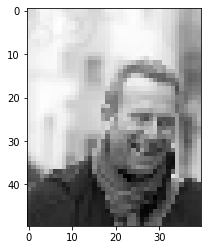

In [ ]:
# TESTIRANJE
itest = load_image(execution_path + 'test-images/1.jpg')
itest = scale_to_normal_size(itest)
scores = []
for x in clf_hog:
  score, score_window, w = process_image(itest, x[0], x[1], step_size=10, window_size=x[2])
  scores.append((score, score_window, w))
image = get_best_image(scores)
display_image(image[2])
print(image[0])

# KLASIFIKACIJA POLA

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import matplotlib
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob
from keras.models import load_model
from tensorflow.keras.utils import get_file
from google.colab import drive
from os.path import exists

drive.mount('/content/gdrive')
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def build_model(width, height, depth, classes):
  model = Sequential()
  inputShape = (height, width, depth)
  chanDim = -1

  if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1

  model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(128, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(classes))
  model.add(Activation("sigmoid"))

  return model

In [ ]:
# TRENIRANJE

if not exists(execution_path + "gender_model/model/keras_metadata.pb"):
  epochs = 100
  lr = 1e-3
  batch_size = 64
  img_dims = (96,96,3)
  data = []
  labels = []
  image_files = [f for f in glob.glob(execution_path + "gender_train" + "/**/*", recursive=True) if not os.path.isdir(f)] 
  random.seed(42)
  random.shuffle(image_files)

  for img in image_files:
      image = cv2.imread(img)
      image = cv2.resize(image, (img_dims[0],img_dims[1]))
      image = img_to_array(image)
      data.append(image)
      label = img.split(os.path.sep)[-2]
      if label == "woman":
          label = 1
      else:
          label = 0
      labels.append([label])

  data = np.array(data, dtype="float") / 255.0
  labels = np.array(labels)
  (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                    random_state=42)
  trainY = to_categorical(trainY, num_classes=2)
  testY = to_categorical(testY, num_classes=2)
  aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                          height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                          horizontal_flip=True, fill_mode="nearest")
  model = build_model(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                              classes=2)
  opt = Adam(lr=lr, decay=lr/epochs)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                          validation_data=(testX,testY),
                          steps_per_epoch=len(trainX) // batch_size,
                          epochs=epochs, verbose=1)

  model.save(execution_path + "gender_model/model")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
28/28 [==============================] - 58s 2s/step - loss: 0.8291 - accuracy: 0.7008 - val_loss: 0.7145 - val_accuracy: 0.4968
Epoch 2/100
28/28 [==============================] - 56s 2s/step - loss: 0.5185 - accuracy: 0.7998 - val_loss: 0.7301 - val_accuracy: 0.4968
Epoch 3/100
28/28 [==============================] - 56s 2s/step - loss: 0.4147 - accuracy: 0.8428 - val_loss: 0.6930 - val_accuracy: 0.5140
Epoch 4/100
28/28 [==============================] - 56s 2s/step - loss: 0.3720 - accuracy: 0.8585 - val_loss: 0.7314 - val_accuracy: 0.5032
Epoch 5/100
28/28 [==============================] - 56s 2s/step - loss: 0.3434 - accuracy: 0.8641 - val_loss: 0.9947 - val_accuracy: 0.5032
Epoch 6/100
28/28 [==============================] - 56s 2s/step - loss: 0.3291 - accuracy: 0.8792 - val_loss: 1.4248 - val_accuracy: 0.5032
Epoch 7/100
28/28 [==============================] - 56s 2s/step - loss: 0.2627 - accuracy: 0.9038 - val_loss: 1.6817 - val_accuracy: 0.5032
Epoch 8/100
2

In [ ]:
# TESTIRANJE

face = cv2.imread(execution_path + "test-images/9.PNG")
if face is None:
    print("Could not read input image")
    exit()

model = load_model(execution_path + "gender_model/model")

face_crop = cv2.resize(face, (96,96))
face_crop = face_crop.astype("float") / 255.0
face_crop = img_to_array(face_crop)
face_crop = np.expand_dims(face_crop, axis=0)
conf = model.predict(face_crop)[0]
print("Man: " + str(conf[0]))
print("Woman: " + str(conf[1]))

Man: 0.46774414
Woman: 0.36409104
